# 1. Importing Library

In [1]:
#basic
import pandas as pd
import os
import sys
import re
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm

from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

<ipython-input-1-a997ab85bbce>:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# 2. Configuration

In [2]:
class CFG:
    data_path = 'data/df.csv'
    print(os.getcwd())

C:\Users\ckdgu\PycharmProjects\pythonProject1


# 3. Data Preprocessing

In [3]:
#data read
df = pd.read_csv(CFG.data_path, header=0, dtype={'date_ori': str})
df

,date_ori,name_ori,item_ori,volumn_ori,count_ori,kind,name,sub_name,agent,category,volumn,count,year,month,item1,item2,category1,category2,category3
0,2013.01,1011부대,UPS,10KVA,1,s,1011부대,NaN,NaN,"사회,공공기관 > 행정기관 > 병무청 > 신병교육대",10.0,1.0,2013,1,장비,UPS,공공기관,군부대,병무청
1,2013.03,1011부대,UPS,10KVA,1,m,1011부대,NaN,NaN,"사회,공공기관 > 행정기관 > 병무청 > 신병교육대",10.0,1.0,2013,3,장비,UPS,공공기관,군부대,병무청
2,2016.12,1017부대-대농이앤씨,이전설치,NaN,1,m,1017부대,NaN,대농이앤씨,"사회,공공기관 > 행정기관 > 병무청 > 신병교육대",NaN,1.0,2016,12,점검/수리,설치,공공기관,군부대,병무청
3,2019.05,1017부대,UPS,10KVA,1,m,1017부대,NaN,NaN,"사회,공공기관 > 행정기관 > 병무청 > 신병교육대",10.0,1.0,2019,5,장비,UPS,공공기관,군부대,병무청
4,2020.05,13항공여단,점검,NaN,1,s,13항공여단,NaN,NaN,"사회,공공기관 > 행정기관 > 병무청 > 신병교육대",NaN,1.0,2020,5,점검/수리,점검/유지보수,공공기관,군부대,병무청
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16903,2013.08,힐네트윅스,UPS,10K/5K,7,s,힐네트윅스,NaN,NaN,"서비스,산업 > 인터넷,IT",5.0,3.5,2013,8,장비,UPS,정보통신,정보통신,IT기업
16904,2013.1,힐네트윅스,UPS,10K/5K,7,m,힐네트윅스,NaN,NaN,"서비스,산업 > 인터넷,IT",10.0,3.5,2013,10,장비,UPS,정보통신,정보통신,IT기업
16905,2013.1,힐네트윅스,UPS,10K/5K,7,m,힐네트윅스,NaN,NaN,"서비스,산업 > 인터넷,IT",5.0,3.5,2013,10,장비,UPS,정보통신,정보통신,IT기업
16906,2014.01,힐네트윅스,UPS,10K/5K,7,m,힐네트윅스,NaN,NaN,"서비스,산업 > 인터넷,IT",10.0,3.5,2014,1,장비,UPS,정보통신,정보통신,IT기업


In [4]:
#data 가공
df = df[df['kind'] == 's']
df = df[df['item2'].str.contains('UPS')]
df['item2'] = df['item2'].replace('UPS외', 1)
df['item2'] = df['item2'].replace('UPS', 1)
df = df.loc[:,['date_ori', 'item2', 'category1', 'count', 'volumn']]
df

,date_ori,item2,category1,count,volumn
0,2013.01,1,공공기관,1.0,10.0
9,2013.05,1,공공기관,1.0,5.0
12,2014.12,1,공공기관,1.0,20.0
13,2019.08,1,공공기관,1.0,5.0
15,2014.02,1,민간기업,1.0,3.0
...,...,...,...,...,...
16885,2012.06,1,정보통신,1.5,3.0
16888,2011.09,1,민간기업,3.0,5.0
16889,2011.09,1,민간기업,3.0,3.0
16902,2013.08,1,정보통신,3.5,10.0


In [5]:
df = df.groupby(by=['date_ori', 'category1'], as_index=False).sum() #전체 data에 대한 금액 합산(용량, count)
df

,date_ori,category1,item2,count,volumn
0,2011.01,공공기관,6,12.0,78.0
1,2011.01,교육기관,3,3.0,75.0
2,2011.01,대리점,3,4.0,87.5
3,2011.01,민간기업,9,52.0,189.0
4,2011.01,정보통신,3,4.0,20.0
...,...,...,...,...,...
626,2020.11,정보통신,1,1.0,30.0
627,2020.12,공공기관,11,29.0,153.0
628,2020.12,교육기관,6,8.0,143.0
629,2020.12,대리점,2,2.0,57.5


In [6]:
# index 설정
df['date_ori'] = df['date_ori'].astype('str')
df = df.reset_index(drop=True)
## 10월 변경
for i in range(len(df)):
    date_ori = df.loc[i,'date_ori']
    split_list = date_ori.split('.')
    if split_list[1] == '1':
        df.loc[i,'date_ori'] = date_ori + '0'
df

,date_ori,category1,item2,count,volumn
0,2011.01,공공기관,6,12.0,78.0
1,2011.01,교육기관,3,3.0,75.0
2,2011.01,대리점,3,4.0,87.5
3,2011.01,민간기업,9,52.0,189.0
4,2011.01,정보통신,3,4.0,20.0
...,...,...,...,...,...
626,2020.11,정보통신,1,1.0,30.0
627,2020.12,공공기관,11,29.0,153.0
628,2020.12,교육기관,6,8.0,143.0
629,2020.12,대리점,2,2.0,57.5


In [7]:
#총 UPS를 수주한 갯수만 사용할 것이므로 count열만 불러낸다
df = df[['date_ori', 'category1', 'count']]


# 4. Model(공공기관)

In [8]:
# category = 공공기관
df_public = df[df['category1'] == '공공기관']
df_public = df_public[['date_ori', 'count']]
df_public

,date_ori,count
0,2011.01,12.0
5,2011.02,6.0
10,2011.03,64.0
15,2011.04,23.0
18,2011.05,61.0
...,...,...
606,2020.08,7.0
611,2020.09,22.8
617,2020.10,10.0
622,2020.11,30.0


In [9]:
## 시계열 그래프 개형
df_public['date_ori'] = pd.to_datetime(df_public['date_ori'])
df_public = df_public.set_index('date_ori')
df_public

,count
date_ori,
2011-01-01,12.0
2011-02-01,6.0
2011-03-01,64.0
2011-04-01,23.0
2011-05-01,61.0
...,...
2020-08-01,7.0
2020-09-01,22.8
2020-10-01,10.0


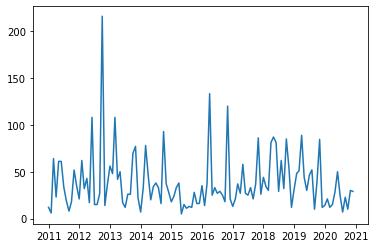

In [10]:
plt.plot(df_public.index, df_public)
plt.show()

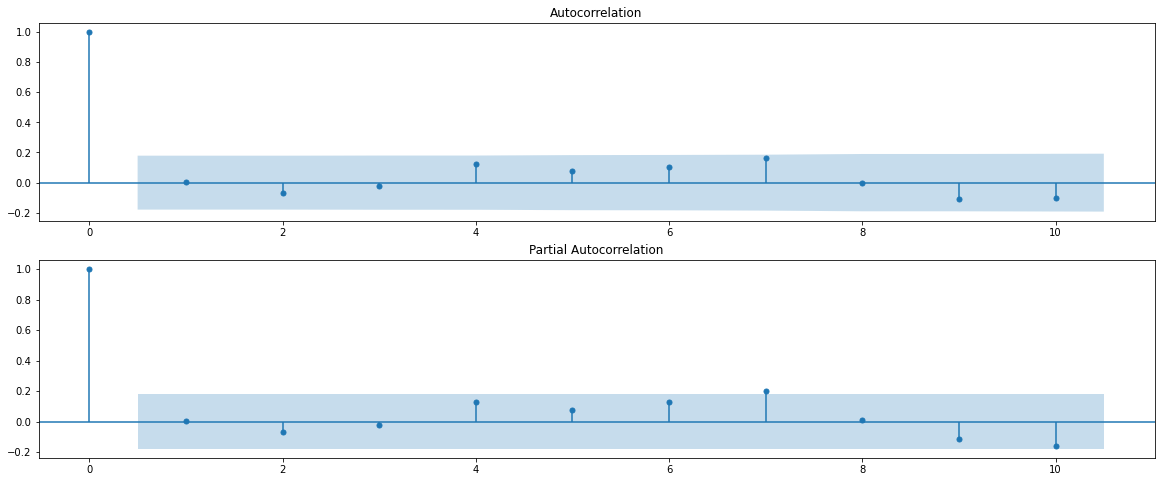

In [11]:
#ACF, PACF 확인
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_public, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_public, lags=10, ax=ax2)

In [12]:
result = adfuller(df_public)
result[2] #p-value의 값

0

In [13]:
#train / test split
train = df_public[0:108]
test = df_public[108:120]

In [14]:
#auto arima(안쓰는듯, 물어볼예정)
#model_arima = auto_arima(train, trace=True, error_action='ignore', strat_p=0, strat_q=0, max_p=3, max_q=3, suppress_warinings=True, stepwise=False, seasonal=False)

In [15]:
#sarima train
abc = SARIMAX(train, order=(3,0,0), seasonal_order=(0,0,0,12))
abc_result = abc.fit(disp=0)
print(abc_result.summary())

C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  108
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -541.357
Date:                Mon, 30 Aug 2021   AIC                           1090.714
Time:                        10:02:37   BIC                           1101.442
Sample:                    01-01-2011   HQIC                          1095.064
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2978      0.089      3.343      0.001       0.123       0.472
ar.L2          0.2265      0.139      1.629      0.103      -0.046       0.499
ar.L3          0.2884      0.143      2.022      0.0

C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


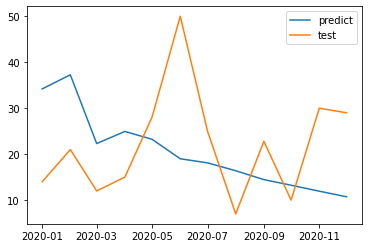

In [16]:
#sarima test
abc_pred = abc_result.predict(start = test.index[0], end = test.index[-1])
plt.plot(test.index,abc_pred,test.index,test)
plt.legend(['predict','test'])
plt.show()

In [17]:
sarima_rmse = np.sqrt(mean_squared_error(y_true = test['count'].values, y_pred = abc_pred.values))
sarima_mse = (mean_squared_error(y_true = test['count'].values, y_pred = abc_pred.values))
print('rmse :', sarima_rmse)
print('mse  :', sarima_mse)

rmse : 15.10476127299283
mse  : 228.15381311410397


# 5. Model(대리점)

In [18]:
#대리점
df_store = df[df['category1'] == '대리점']
df_store = df_store[['date_ori', 'count']]
df_store

,date_ori,count
2,2011.01,4.0
7,2011.02,1.0
12,2011.03,6.0
21,2011.05,8.0
26,2011.06,16.0
...,...,...
608,2020.08,4.0
614,2020.09,3.0
619,2020.10,10.0
624,2020.11,8.0


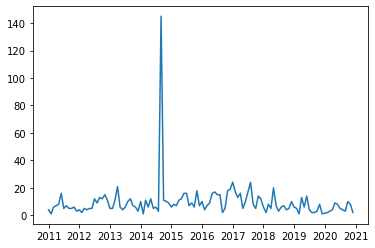

In [19]:
## 시계열 그래프 개형
df_store['date_ori'] = pd.to_datetime(df_store['date_ori'])
df_store = df_store.set_index('date_ori')
plt.plot(df_store.index, df_store)
plt.show()

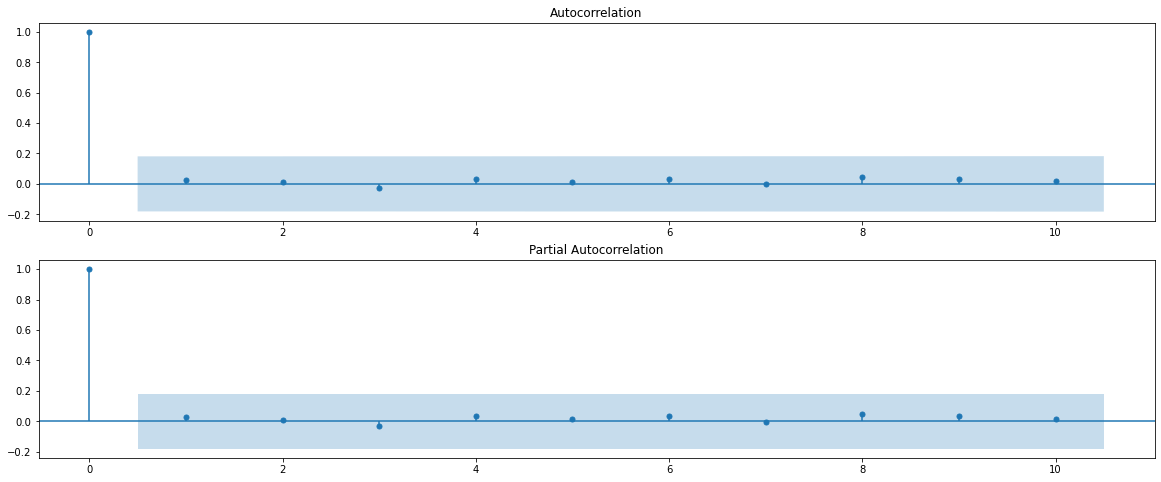

In [20]:
#ACF, PACF 확인
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_store, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_store, lags=10, ax=ax2)

In [21]:
##
result = adfuller(df_store)
result[2] #p-value의 값

0

In [22]:
#train / test split
train = df_store[0:105]
test = df_store[106:117]


In [23]:
#auto arima(안쓰는듯, 물어볼예정)
#model_arima = auto_arima(train, trace=True, error_action='ignore', strat_p=0, strat_q=0, max_p=3, max_q=3, suppress_warinings=True, stepwise=False, seasonal=False)

In [24]:
#sarima train
abc = SARIMAX(df_store, order=(1,0,1), seasonal_order=(0,0,0,12))
abc_result = abc.fit(disp=0)
print(abc_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  117
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -473.290
Date:                Mon, 30 Aug 2021   AIC                            952.581
Time:                        10:02:38   BIC                            960.867
Sample:                             0   HQIC                           955.945
                                - 117                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9957      0.024     40.975      0.000       0.948       1.043
ma.L1         -0.9440      0.133     -7.111      0.000      -1.204      -0.684
sigma2       188.8630      8.212     22.997      0.0

C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\envs\pythonProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


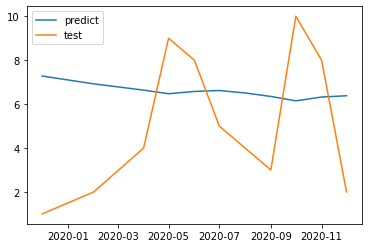

In [25]:
#sarima test
abc_pred = abc_result.predict(start = test.index[0], end = test.index[-1])
plt.plot(test.index,abc_pred,test.index,test)
plt.legend(['predict','test'])
plt.show()


In [26]:
sarima_rmse = np.sqrt(mean_squared_error(y_true = test['count'].values, y_pred = abc_pred.values))
sarima_mse = (mean_squared_error(y_true = test['count'].values, y_pred = abc_pred.values))
print('rmse :', sarima_rmse)
print('mse  :', sarima_mse)

rmse : 3.5157122852804266
mse  : 12.360232872871718
